# Coding Practice: Agent-Based Modeling

In this notebook, we'll code up the simple random walk and PageRank random walk using the mesa framework for agent-based modeling. All the code in these notebooks (as well as outputs) can be found in the [online lecture notes](https://www.philchodrow.com/intro-networks/chapters/agent_based_modeling.html#first-example-simple-random-walk). 

Because we're going to be focusing on the agent-based modeling angle, I've pre-populated some of the boiler plate code for you. 

In [1]:
from mesa import Model, Agent                 # core mesa classes
from mesa.space import NetworkGrid             
from mesa.time import BaseScheduler           
from mesa.datacollection import DataCollector

import networkx as nx                         # for the grid
import numpy as np                            # computations
from matplotlib import pyplot as plt          # visualizing output

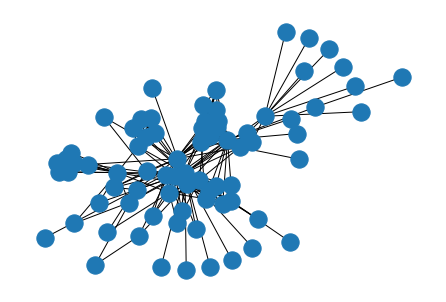

In [2]:
G = nx.les_miserables_graph()
nx.draw(G)

First, we'll define our model. 

In [3]:
class RWModel(Model):

    # model setup
    def __init__(self, G, agent_class, **kwargs):
        
        self.schedule = BaseScheduler(self) # time structure
        self.grid     = NetworkGrid(G)      # space structure
        
        # create a single agent who will walk around the graph
        # we haven't defined SWRAgent yet
        # the agent has a name and is associated to the model
        agent = agent_class("Anakin Graphwalker", self, **kwargs)

        # place the agent at a random node on the graph
        node = self.random.choice(list(G.nodes))
        self.grid.place_agent(agent, node)
        
        # place the agent into the schedule
        self.schedule.add(agent)
        
        # data collection. Here we're just going to collect the 
        # current position of each agent
        self.collector = DataCollector(
            agent_reporters = {
                "node" : lambda a: a.pos
        })

    # this is where a timestep actually happens
    # once we've set up the model's __init__() method
    # and the step() method of the agent class, 
    # this is one is usually pretty simple
    
    def step(self):
        self.schedule.step()
        self.collector.collect(self)

Notice that the model includes placing a single agent on the grid, but we haven't actually defined any agents. So, that needs to be our next step. We've deliberately allowed the model to accept agents of different kinds; here we'll implement an agent that performs the simple random walk behavior. 

In [4]:
class SRWAgent(Agent):

    def step(self):
        
        # find all possible next steps
        # include_center determines whether or not we count the 
        # current position as a possibility
        options = self.model.grid.get_neighbors(self.pos,
                                                include_center = False)
        # pick a random one and go there
        new_node = self.random.choice(options)
        self.model.grid.move_agent(self, new_node)

Now we can simulate our model! We instantiate a model using the graph, specifying that we want the single agent to be an `SRWAgent`. 

In [5]:
model = RWModel(G, SRWAgent)

for i in range(100000):
    model.step()

We can get a report of where the walker was at each time step: 

In [6]:
walk_report = model.collector.get_agent_vars_dataframe()
walk_report.head()

,,node
Step,AgentID,
1,Anakin Graphwalker,Magnon
2,Anakin Graphwalker,MmeThenardier
3,Anakin Graphwalker,Cosette
4,Anakin Graphwalker,MmeThenardier
5,Anakin Graphwalker,Fantine


This allows us to compute the proportion of time the walker spent at each node: 

In [8]:
counts = walk_report.groupby("node").size()
freqs = counts / sum(counts)
freqs

node
Anzelma       0.00608
Babet         0.02075
Bahorel       0.02365
Bamatabois    0.01591
BaronessT     0.00398
               ...   
Toussaint     0.00607
Valjean       0.07111
Woman1        0.00392
Woman2        0.00563
Zephine       0.01313
Length: 77, dtype: float64

Let's finally compare this to the theoretical prediction that the amount of time spent at a node should be proportional to the node's degree: 

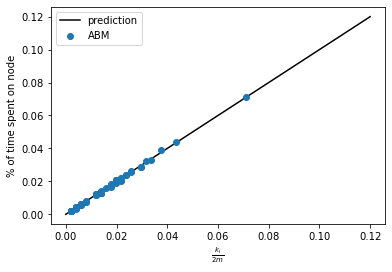

In [9]:
degs = [G.degree(i) for i in freqs.index]
stationary_dist = degs / np.sum(degs)

plt.plot([0, .12], 
         [0, .12], 
         color = "black", label = "prediction")

plt.scatter(stationary_dist, 
            freqs, 
            zorder = 100, label = "ABM")

plt.gca().set(xlabel = r"$\frac{k_i}{2m}$", 
              ylabel = "% of time spent on node")

plt.legend()

Because we allowed our model to accept different kinds of agents, we can implement a PageRank random walk simply by implementing a new agent class: 

In [10]:
class PageRankAgent(Agent):
    
    def __init__(self, agent_id, model, alpha):
        super().__init__(agent_id, model)
        self.alpha = alpha
    
    def step(self):
        if np.random.rand() < self.alpha:
            options = list(model.grid.G.nodes.keys())
        else:
            options = self.model.grid.get_neighbors(self.pos,
                                                    include_center = False)
        # pick a random one and go there
        new_node = self.random.choice(options)
        self.model.grid.move_agent(self, new_node)

We could compare the PR random walk behavior to the leading eigenvector of the PageRank transition matrix, but instead let's just compute it and then draw it on the graph: 

In [11]:
pagerank_model = RWModel(G, PageRankAgent, alpha = 0.15)

for i in range(100000):
    pagerank_model.step()


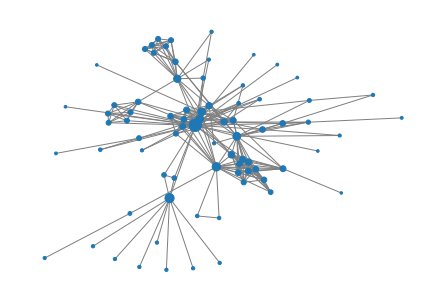

In [12]:
walk_report = pagerank_model.collector.get_agent_vars_dataframe()

counts = walk_report.groupby("node").size()
freqs  = counts / np.sum(counts)

nx.draw(G, 
        node_size = [2000*freqs[i] for i in G.nodes], 
        edge_color = "grey")

In [13]:
nx.__version__

'2.8'

In [16]:
?nx.algorithms.community.modularity

In [15]:
A = nx.to_numpy_array(G)

array([[0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 8., ..., 0., 0., 0.],
       [0., 8., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])